In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
import subprocess

num_steps_users = 12  # Number of steps for users
num_steps_sizes = 12  # Number of steps for payload sizes
run_time_seconds = 60  # Number of seconds to run each test
num_workers = 4 # Number of workers to use for each test

payload_sizes = np.unique(np.logspace(0, 24, num=num_steps_sizes, base=2).astype(int))  # Logarithmically spaced sizes, ensure unique values
num_users_list = np.unique(np.logspace(0, 12, num=num_steps_users, base=2).astype(int))  # Logarithmically spaced users, ensure unique values


# fix user, small files between 1byte and 100kb
#min_size_log2 = 0  # log2(1 byte)
#max_size_log2 = log(100 * 1024, 2)  # log2(100 KB)
#num_steps_sizes = 32  # Number of steps for payload sizes
#payload_sizes = np.unique(np.logspace(min_size_log2, max_size_log2, num=num_steps_sizes, base=2).astype(int))
#num_users_list = np.full(1, 500)

ModuleNotFoundError: No module named 'numpy'

In [ ]:

tasks = []
for payload_size in payload_sizes:
    for num_users in num_users_list:
        task = {
            "num_users": num_users,
            "spawn_rate": num_users,  # Adjust as needed
            "payload_size": payload_size,
            "csv_filename": f"results_{payload_size}_{num_users}"
        }
        tasks.append(task)

# View first 5 tasks as an example
tasks_df = pd.DataFrame(tasks)

pd.set_option('display.max_rows', None)
print(tasks_df)
pd.reset_option('display.max_rows')


     num_users  spawn_rate  payload_size           csv_filename
0            1           1             1            results_1_1
1            2           2             1            results_1_2
2            4           4             1            results_1_4
3            9           9             1            results_1_9
4           20          20             1           results_1_20
5           43          43             1           results_1_43
6           93          93             1           results_1_93
7          198         198             1          results_1_198
8          423         423             1          results_1_423
9          902         902             1          results_1_902
10        1922        1922             1         results_1_1922
11        4096        4096             1         results_1_4096
12           1           1             4            results_4_1
13           2           2             4            results_4_2
14           4           4             4

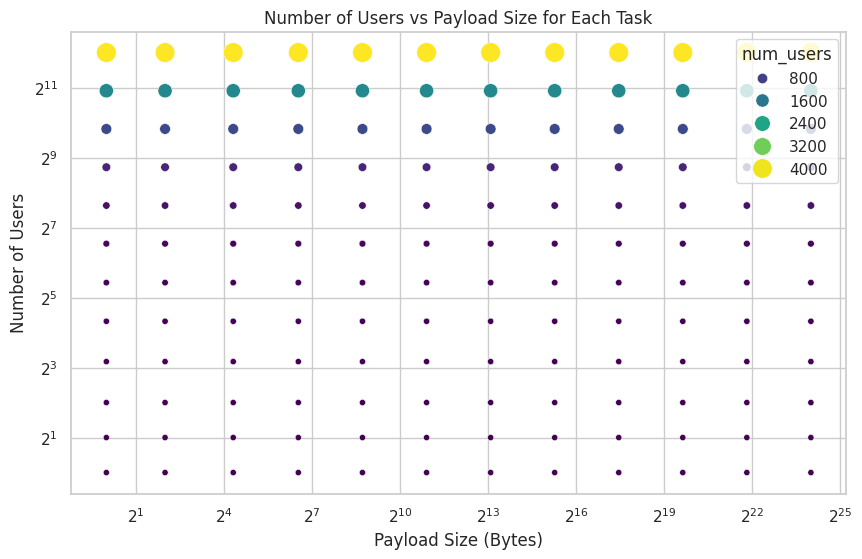

In [ ]:
# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=tasks_df, x='payload_size', y='num_users', size='num_users', hue='num_users', palette='viridis', sizes=(20, 200))

# Set the scale of the x/y-axis to logarithmic to better visualize the data
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)

# Set plot labels and title
ax.set_xlabel('Payload Size (Bytes)')
ax.set_ylabel('Number of Users')
ax.set_title('Number of Users vs Payload Size for Each Task')

# Show the plot
plt.show()

In [ ]:
def run_benchmark_docker(task):
    results_file_path = f"results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f".{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    # Set environment variables
    os.environ['NUM_USERS'] = str(task['num_users'])
    os.environ['SPAWN_RATE'] = str(task['spawn_rate'])
    os.environ['RUN_TIME'] = str(run_time_seconds)
    os.environ['CSV_FILENAME'] = results_file_path
    os.environ['PAYLOAD_SIZE'] = str(task['payload_size'])
    os.environ['NUM_WORKERS'] = str(num_workers)
    
    # Run the benchmark using Docker Compose
    subprocess.run(["docker", "compose", "up", "--scale", f"locust-worker={num_workers}"], check=True)

    # Optionally, you can stop and remove containers if needed
    subprocess.run(["docker-compose", "down"], check=True)


# Ensure the results directory exists
os.makedirs('.results', exist_ok=True)

#for task in tasks:
#    run_benchmark_docker(task)

In [ ]:
def run_benchmark_local(task):
    results_file_path = f".results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f"{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    # Command to start the Locust master
    master_command = ["locust", "-f", "../locust/locustfile.py", "--master", "--headless", 
                      "--expect-workers", "4",
                      "--host", "http://localhost:8000", 
                      "-u", str(task['num_users']), 
                      "-r", str(task['spawn_rate']), 
                      "--run-time", str(run_time_seconds),
                      "--csv", results_file_path]

    # Commands to start Locust workers
    worker_commands = [
        ["locust", "-f", "../locust/locustfile.py", "--worker", "--master-host", "127.0.0.1"] for _ in range(4)
    ]

    # Start the Locust master
    master_process = subprocess.Popen(master_command)

    # Start the worker processes
    worker_processes = [subprocess.Popen(cmd) for cmd in worker_commands]
    
    try:
        # Wait for the master process to complete
        master_process.wait()
    except KeyboardInterrupt:
        # Handle Ctrl+C
        pass
    finally:
        # Terminate all processes
        master_process.terminate()
        for worker in worker_processes:
            worker.terminate()


# Ensure the results directory exists
os.makedirs('.results', exist_ok=True)

for task in tasks:
    run_benchmark_local(task)

In [ ]:
results = []
for task in tasks:
    csv_filename = f".results/{task['csv_filename']}_stats.csv"
    try:
        df = pd.read_csv(csv_filename)
        if not df.empty:
            agg_row = df.iloc[-1]  # Select the last row
            if agg_row["Name"] == "Aggregated":
                results.append({
                    "payload_size": task["payload_size"],
                    "num_users": task["num_users"],
                    "total_requests": int(agg_row["Request Count"]),
                    "avg_response_time": float(agg_row["Average Response Time"]),
                })
            else:
                print(f"No aggregated data found in {csv_filename}")
        else:
            print(f"The CSV file is empty: {csv_filename}")
    except FileNotFoundError:
        print(f"Results not found for task: {task}")
    except Exception as e:
        print(f"An error occurred for task {task}: {str(e)}")

results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
print(results_df)
pd.reset_option('display.max_rows')


     payload_size  num_users  total_requests  avg_response_time
0               1          1           88346           0.005467
1               1          2          150299           0.040320
2               1          4          194340           0.755717
3               1          9          212700           1.865120
4               1         20          210222           4.732611
5               1         43          220906          10.013630
6               1         93          228071          21.733294
7               1        198          228463          47.874842
8               1        423          228277         102.463897
9               1        902          237669         109.057243
10              1       1922          221983         440.508368
11              1       4096          215067        1002.525436
12              4          1           88552           0.002620
13              4          2          148569           0.043131
14              4          4          18

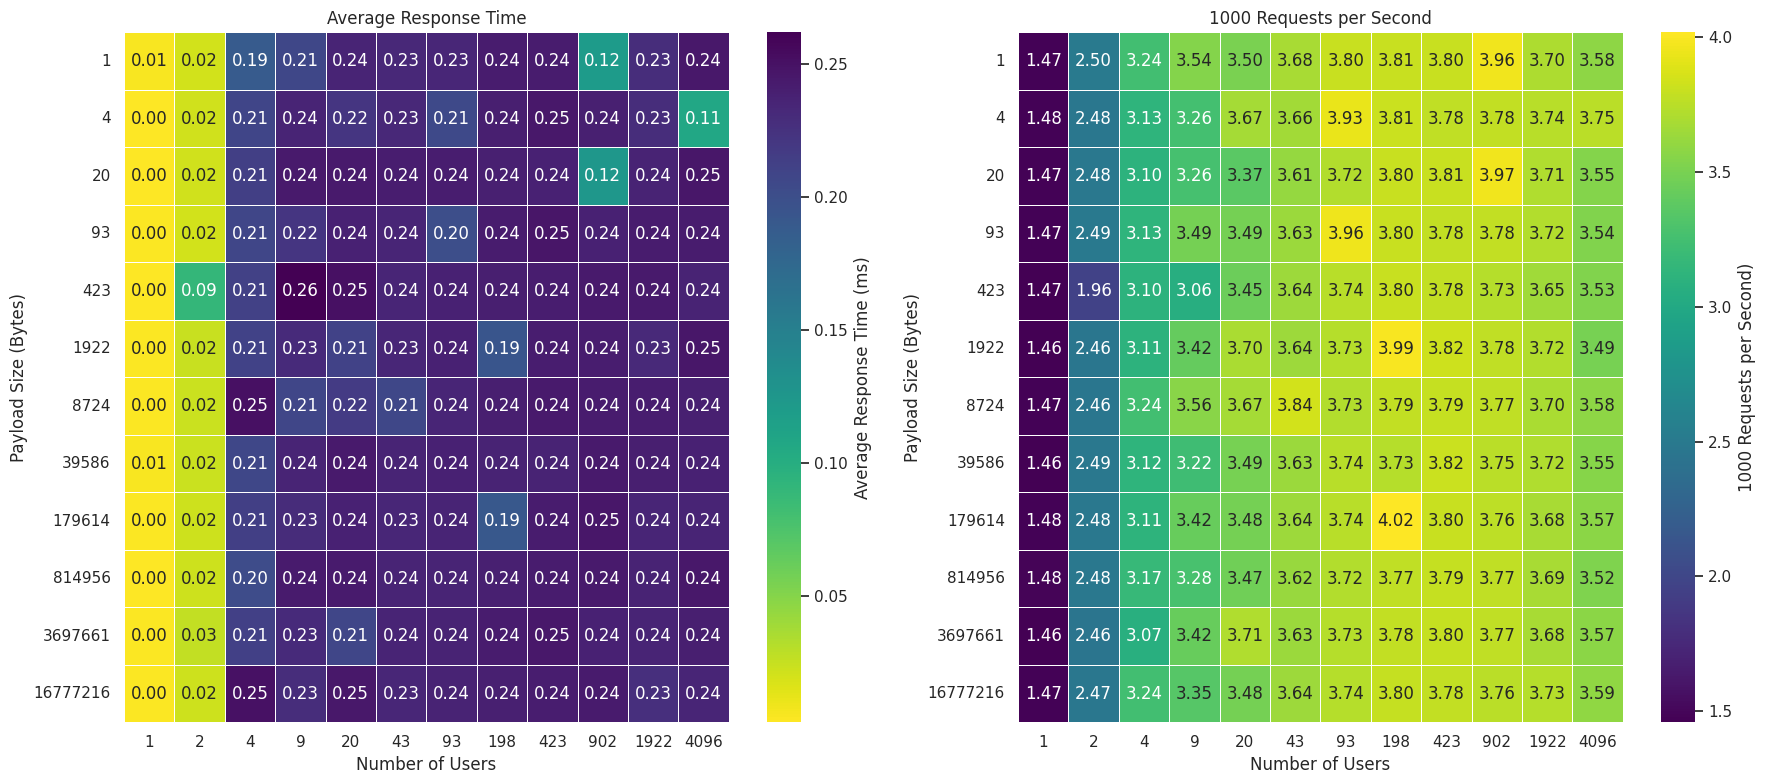

In [ ]:
# Add columns for requests per second and requests per second
results_df['requests_per_second'] = results_df['total_requests'] / run_time_seconds / 1000

results_df['avg_response_time_per_user'] = results_df['avg_response_time'] / results_df['num_users']

# Pivot the DataFrames for the heatmaps
heatmap_data_rps = results_df.pivot(index="payload_size", columns="num_users", values="requests_per_second")
heatmap_data_rt = results_df.pivot(index="payload_size", columns="num_users", values="avg_response_time_per_user")

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Draw the heatmap for average response time
sns.heatmap(heatmap_data_rt, cmap="viridis_r", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"label": "Average Response Time (ms)"}, ax=axes[0])
axes[0].set_title('Average Response Time')
axes[0].set_xlabel('Number of Users')
axes[0].set_ylabel('Payload Size (Bytes)')

# Draw the heatmap for requests per second per user
sns.heatmap(heatmap_data_rps, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"label": "1000 Requests per Second)"}, ax=axes[1])
axes[1].set_title('1000 Requests per Second')
axes[1].set_xlabel('Number of Users')
axes[1].set_ylabel('Payload Size (Bytes)')

plt.tight_layout()
plt.show()


In [ ]:
print( results_df['num_users'])

0         1
1         2
2         4
3         9
4        20
       ... 
139     198
140     423
141     902
142    1922
143    4096
Name: num_users, Length: 144, dtype: int64


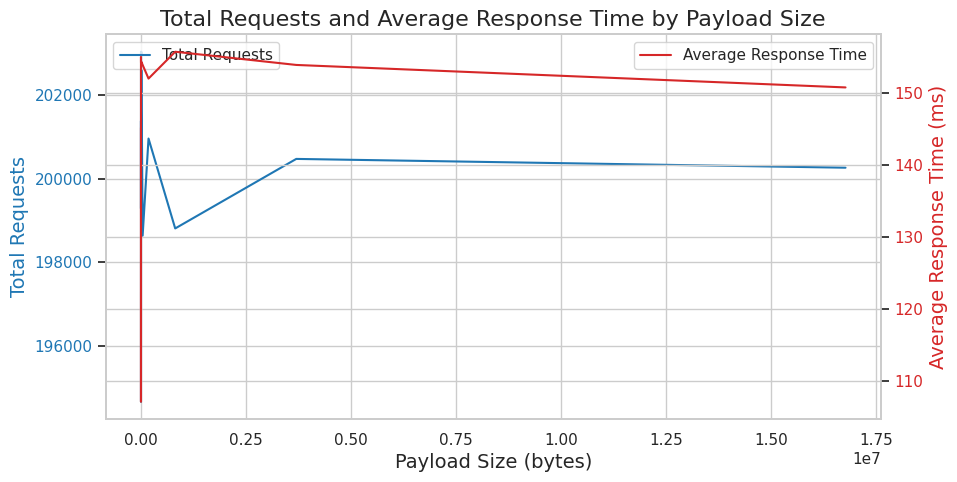

In [ ]:
# Assuming 'results_df' is your DataFrame

# First, we will group the data by 'payload_size' and calculate the mean 'total_requests' and 'avg_response_time'.
# This is necessary because your data seems to have multiple entries for each 'payload_size'.
grouped = results_df.groupby('payload_size').mean().reset_index()

# Now let's plot the data
fig, ax1 = plt.subplots(figsize=(10, 5))

# Set the x-axis label
ax1.set_xlabel('Payload Size (bytes)', fontsize=14)

# Plot the 'total_requests' on the left y-axis
ax1.set_ylabel('Total Requests', color='tab:blue', fontsize=14)
ax1.plot(grouped['payload_size'], grouped['total_requests'], color='tab:blue', label='Total Requests')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to share the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Average Response Time (ms)', color='tab:red', fontsize=14)  # we already handled the x-label with ax1
ax2.plot(grouped['payload_size'], grouped['avg_response_time'], color='tab:red', label='Average Response Time')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set the title of the plot
plt.title('Total Requests and Average Response Time by Payload Size', fontsize=16)

# Show a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

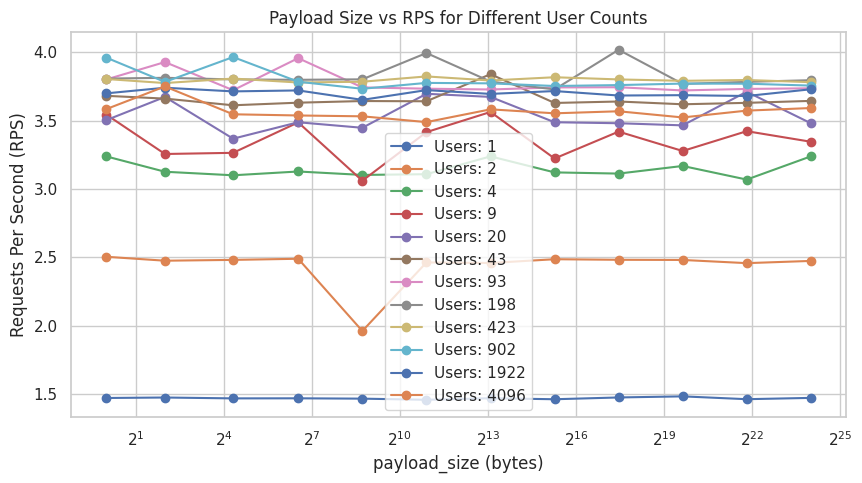

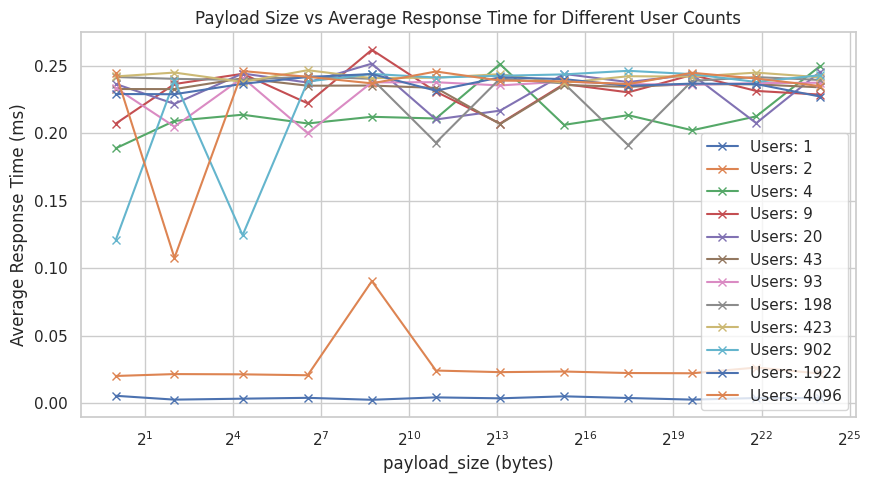

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming results_df is your DataFrame with correct column names
# Add columns for requests per second and requests per second
results_df['requests_per_second'] = results_df['total_requests'] / run_time_seconds / 1000

results_df['avg_response_time_per_user'] = results_df['avg_response_time'] / results_df['num_users']

# Set up the plot for total_requests (RPS)
plt.figure(figsize=(10, 5))
for name, group in results_df.groupby('num_users'):
    plt.plot(group['payload_size'], group['requests_per_second'], label=f'Users: {name}', marker='o')
plt.xlabel('payload_size (bytes)')
plt.ylabel('Requests Per Second (RPS)')
plt.xscale('log', base=2)
plt.legend()
plt.title('Payload Size vs RPS for Different User Counts')
plt.show()

# Set up the plot for avg_response_time
plt.figure(figsize=(10, 5))
for name, group in results_df.groupby('num_users'):
    plt.plot(group['payload_size'], group['avg_response_time_per_user'], label=f'Users: {name}', marker='x')
plt.xlabel('payload_size (bytes)')
plt.ylabel('Average Response Time (ms)')
plt.xscale('log', base=2)
plt.legend()
plt.title('Payload Size vs Average Response Time for Different User Counts')
plt.show()
